In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.dates as mdates

2023-12-02 18:56:48.210920: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Volumes/DataQ/Tugas Akhir/lstm-predict-potato-price/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def load_data_preprocessing(pick_harga):
    # load dataset csv harga 
    df = pd.read_csv(f"data/timeseries-{pick_harga}-wonosobo.csv")
    return df[['tanggal', 'harga']]

In [3]:
#load data
data = load_data_preprocessing('CRM')
data.set_index('tanggal', inplace=True)
data.tail()

,harga
tanggal,
2023-11-21,65000.0
2023-11-22,65000.0
2023-11-23,65000.0
2023-11-24,67500.0
2023-11-25,70000.0


In [4]:
# Split data into training (2010-2020) and validation (2020-2023) sets
training_data = data['harga']['2021-01-01':'2021-12-30']
validation_data = data['harga']['2023-01-01':'2023-11-25']

In [5]:
# Use 'Adj Close' prices as the stock price for training
training_set = training_data.values.reshape(-1, 1)
validation_set = validation_data.values.reshape(-1, 1)

In [14]:
# Feature scaling using MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
# training_set_scaled = sc.fit_transform(training_set)
# validation_set_scaled = sc.transform(validation_set)
training_set_scaled = training_set
validation_set_scaled = validation_set


In [15]:
# Creating input sequences for training
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(training_set_scaled)
X_validation, y_validation = create_sequences(validation_set_scaled)

# Reshape inputs for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))
X_train

array([[[61000.],
        [65000.],
        [65000.],
        ...,
        [75000.],
        [75000.],
        [75000.]],

       [[65000.],
        [65000.],
        [57000.],
        ...,
        [75000.],
        [75000.],
        [75000.]],

       [[65000.],
        [57000.],
        [65000.],
        ...,
        [75000.],
        [75000.],
        [75000.]],

       ...,

       [[19000.],
        [18000.],
        [18000.],
        ...,
        [70000.],
        [70000.],
        [70000.]],

       [[18000.],
        [18000.],
        [17000.],
        ...,
        [70000.],
        [70000.],
        [70000.]],

       [[18000.],
        [17000.],
        [15000.],
        ...,
        [70000.],
        [70000.],
        [70000.]]])

In [16]:
# Building the LSTM Model
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1))

In [17]:
# Compiling the LSTM Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the Model and store history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/100
10/10 [==============================] - 9s 258ms/step - loss: 1700603904.0000 - val_loss: 1322474880.0000
Epoch 2/100
10/10 [==============================] - 1s 108ms/step - loss: 1700388224.0000 - val_loss: 1322303488.0000
Epoch 3/100
10/10 [==============================] - 1s 107ms/step - loss: 1700239616.0000 - val_loss: 1322168832.0000
Epoch 4/100
10/10 [==============================] - 1s 111ms/step - loss: 1700111232.0000 - val_loss: 1322070272.0000
Epoch 5/100
10/10 [==============================] - 1s 108ms/step - loss: 1700023424.0000 - val_loss: 1322003200.0000
Epoch 6/100
10/10 [==============================] - 1s 108ms/step - loss: 1699969536.0000 - val_loss: 1321953024.0000
Epoch 7/100
10/10 [==============================] - 1s 121ms/step - loss: 1699913856.0000 - val_loss: 1321910144.0000
Epoch 8/100
10/10 [==============================] - 1s 119ms/step - loss: 1699876608.0000 - val_loss: 1321868928.0000
Epoch 9/100
10/10 [=============================

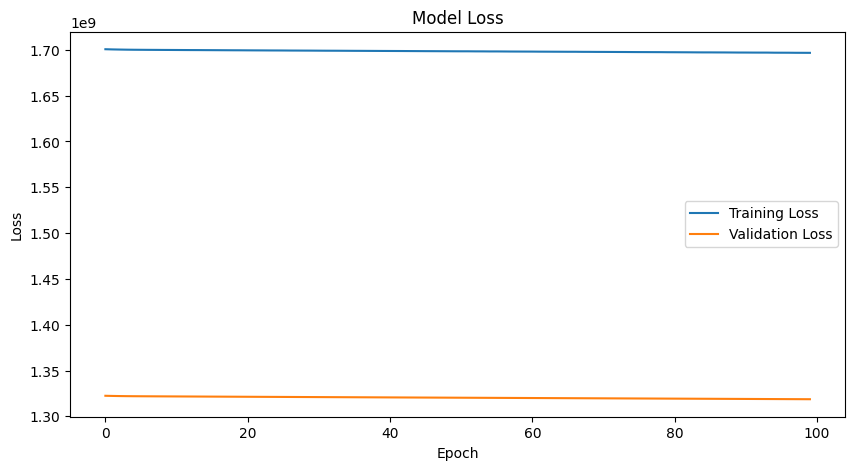

In [18]:
# Plot loss and accuracy during training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Use 'Adj Close' prices as the test data
X_validation
pred = model.predict(X_validation[0])
pred

2/2 [==============================] - 2s 4ms/step


array([[2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],
       [2.2700453],


In [54]:
y_validation[1]

0.4215686274509804

IndexError: tuple index out of range

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(spy_test.index, real_stock_price, color='black', label='SPY Stock Price')
plt.plot(date_range, predicted_stock_price, color='green', label='Predicted SPY Stock Price')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show tick marks for every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.show()
